In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

from IPython.core.display import display, HTML
display(HTML("<style>.container{width:100% !important; }</style>"))

from IPython.display import display
pd.set_option('expand_frame_repr', True) 
pd.set_option('display.unicode.ambiguous_as_wide', True)
pd.set_option('display.unicode.east_asian_width', True)
pd.set_option('display.width', 180) 
plt.style.use('seaborn-darkgrid')
plt.rcParams['font.family'] = ['sans-serif']
plt.rcParams['font.sans-serif'] = ['SimHei'] 
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['figure.figsize'] = (10, 6)
%config InlineBackend.figure_format = 'svg' 
%matplotlib inline


In [2]:
# find all the xls files
import glob
file_list = glob.glob('data/*.xls')
df = pd.concat([pd.read_excel(f, skiprows=10, index_col='observation_date') for f in file_list], axis=1)
df.index.name = 'date'
df.columns = ['1Y', '10Y', '2Y', '3Y', '3M', '5Y', '6M', '7Y']
df = df[['3M', '6M', '1Y', '2Y', '3Y', '5Y', '7Y', '10Y']]

# filter zero value
df = df[df > 0]
df.dropna(inplace=True)
df

,3M,6M,1Y,2Y,3Y,5Y,7Y,10Y
date,,,,,,,,
2014-01-02,0.07,0.09,0.13,0.39,0.76,1.72,2.41,3.00
2014-01-03,0.07,0.10,0.13,0.41,0.80,1.73,2.42,3.01
2014-01-06,0.05,0.08,0.12,0.40,0.78,1.70,2.38,2.98
2014-01-07,0.04,0.08,0.13,0.40,0.80,1.69,2.37,2.96
2014-01-08,0.05,0.08,0.13,0.43,0.87,1.77,2.44,3.01
...,...,...,...,...,...,...,...,...
2024-02-13,5.45,5.32,4.99,4.64,4.44,4.31,4.33,4.31
2024-02-14,5.43,5.31,4.94,4.56,4.38,4.25,4.27,4.27
2024-02-15,5.43,5.30,4.93,4.56,4.36,4.22,4.25,4.24


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2522 entries, 2014-01-02 to 2024-02-20
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   3M      2522 non-null   float64
 1   6M      2522 non-null   float64
 2   1Y      2522 non-null   float64
 3   2Y      2522 non-null   float64
 4   3Y      2522 non-null   float64
 5   5Y      2522 non-null   float64
 6   7Y      2522 non-null   float64
 7   10Y     2522 non-null   float64
dtypes: float64(8)
memory usage: 177.3 KB


In [6]:
df.to_csv('yield.csv', index=True)

**Nelson-Siegel Model**
- A parametric model for the term structure of continuously compounded zero-coupon rates
- An exponential decay function of time to maturity, downward ($\beta_1>0$) and upward ($\beta_1<0$)
- A Laguerre function, generating a hump shape ($\beta_2>0$) or an trough shape ($\beta_2<0$). Higher the absolute value of $\beta_2$, the more pronouced the hump or trough.
- $\beta_0$: long-term interest rate level, the limit as $T\to\infty$
- $\beta_1$: slope parameter, the limit of $Y(T)-\beta_0$ as $T\to 0$, regarded as the long-to-short-term spread
- $\beta_2$: curvature parameter 
- The three parameters of NS model can be directly linked to parallel shifts, slope shifts and curvature changes in the yield curve
- $\lambda=\frac{1}{\tau}$: shape parameter, or the decay parameter, determines both the steepness of the slope and the location of the maximum/minimum of the Laguerre function. In practice, for simplicity, $\lambda$ is often set to $\frac{1}{3.33}$ as suggested by real data.
- NS model allows us to obtain four standard shapes for the zero-coupon yield curve: increasing, decreasing, flat, and inverted.

<AxesSubplot:xlabel='date'>

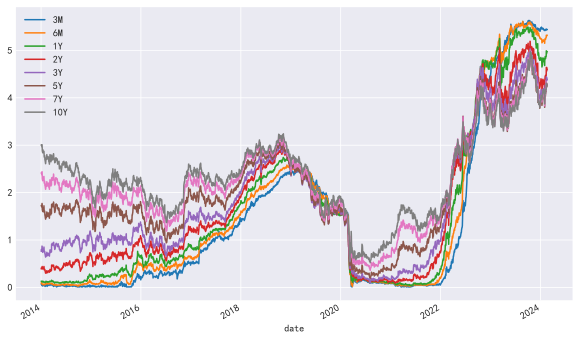

In [7]:
df.plot(figsize=(10, 6))

Directly calibrate four parameters (including the decay) using nonlinear least square

In [8]:
from sklearn.metrics import mean_squared_error

def Nelson_Siegel(T, beta_0, beta_1, beta_2, lambda_):
    term1 = (1 - np.exp(-lambda_ * T)) / (lambda_ * T)
    term2 = term1 - np.exp(-lambda_ * T)
    Y = beta_0 + (beta_1 * term1) + (beta_2 * term2)
    return Y

from scipy.optimize import curve_fit

# Define the calibration function
def calibrate_NS(T, Y_observed):
    # Initial guesses for the parameters
    initial_guess = [0.05, -0.04, -0.05, 1/3.33]

    # Use curve_fit to calibrate the parameters (nonlinear least squares)
    params, covariance = curve_fit(Nelson_Siegel, T, Y_observed, p0=initial_guess, maxfev=5000)

    # Calculate the fitted yield values
    Y_fit = Nelson_Siegel(T, *params)

    # Calculate the RMSE
    rmse = np.sqrt(mean_squared_error(Y_observed, Y_fit))

    return params, rmse

T_values = np.array([0.25, 0.5, 1, 2, 3, 5, 7, 10])  # Maturity values
fitted_df = pd.DataFrame(index=df.index, columns=df.columns, dtype=float)

param_df_v1 = pd.DataFrame(index=df.index, columns=['beta_0', 'beta_1', 'beta_2', 'lambda', 'rmse'], dtype=float)

for idx, row in df.iterrows():
    Y_observed = row.values
    params, rmse = calibrate_NS(T_values, Y_observed)
    param_df_v1.loc[idx, ['beta_0', 'beta_1', 'beta_2', 'lambda']] = params
    param_df_v1.loc[idx, 'rmse'] = rmse

    Y_fit = Nelson_Siegel(T_values, *params)
    fitted_df.loc[idx] = Y_fit

param_df_v1


,beta_0,beta_1,beta_2,lambda,rmse
date,,,,,
2014-01-02,4.826952,-4.635613,-6.146917,0.593009,0.037502
2014-01-03,4.808899,-4.625748,-6.032362,0.594194,0.031150
2014-01-06,4.800457,-4.649299,-5.932418,0.581228,0.029542
2014-01-07,4.762794,-4.628682,-5.781963,0.577263,0.028203
2014-01-08,4.684792,-4.536579,-5.774903,0.617666,0.023846
...,...,...,...,...,...
2024-02-13,4.398438,-85.050880,315.283640,732.163431,0.182419
2024-02-14,4.338194,41.665215,122.095353,501.141745,0.186463
2024-02-15,4.317115,153.938937,148.815163,910.125972,0.190191


<AxesSubplot:title={'center':'RMSE of Nelson-Siegel Model'}, xlabel='date'>

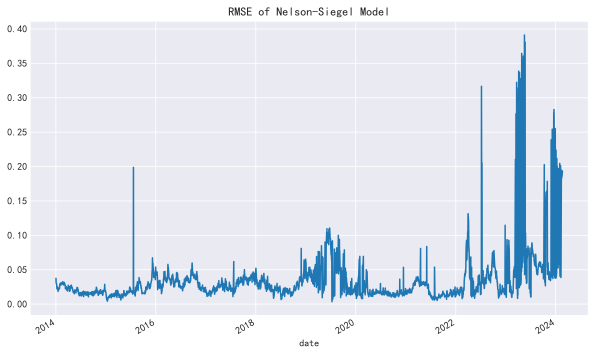

In [9]:
param_df_v1['rmse'].plot(figsize=(10, 6), title='RMSE of Nelson-Siegel Model')

As we see from the error plot, the model calibrates poorly, because of the difficulty in estimating the decay parameter $\lambda$. According to literature, $\lambda$ is often set to $\frac{1}{3.33}$ as suggested by real data. We now fix $\lambda$ to $\frac{1}{3.33}$ and calibrate the other three parameters again.

In [10]:
from sklearn.metrics import mean_squared_error

def Nelson_Siegel(T, beta_0, beta_1, beta_2):
    lambda_ = 1/3.33
    term1 = (1 - np.exp(-lambda_ * T)) / (lambda_ * T)
    term2 = term1 - np.exp(-lambda_ * T)
    Y = beta_0 + (beta_1 * term1) + (beta_2 * term2)
    return Y

from scipy.optimize import curve_fit

# Define the calibration function
def calibrate_NS(T, Y_observed):
    # Initial guesses for the parameters
    initial_guess = [0.05, -0.04, -0.05]

    # Use curve_fit to calibrate the parameters (nonlinear least squares)
    params, covariance = curve_fit(Nelson_Siegel, T, Y_observed, p0=initial_guess, maxfev=5000)

    # Calculate the fitted yield values
    Y_fit = Nelson_Siegel(T, *params)

    # Calculate the RMSE
    rmse = np.sqrt(mean_squared_error(Y_observed, Y_fit))

    return params, rmse

T_values = np.array([0.25, 0.5, 1, 2, 3, 5, 7, 10])  # Maturity values
fitted_df = pd.DataFrame(index=df.index, columns=df.columns, dtype=float)

param_df = pd.DataFrame(index=df.index, columns=['beta_0', 'beta_1', 'beta_2', 'rmse'], dtype=float)

for idx, row in df.iterrows():
    Y_observed = row.values
    params, rmse = calibrate_NS(T_values, Y_observed)
    param_df.loc[idx, ['beta_0', 'beta_1', 'beta_2']] = params
    param_df.loc[idx, 'rmse'] = rmse

    Y_fit = Nelson_Siegel(T_values, *params)
    fitted_df.loc[idx] = Y_fit

print("Total RMSE: ", param_df['rmse'].sum())
param_df


Total RMSE:  135.53242777988106


,beta_0,beta_1,beta_2,rmse
date,,,,
2014-01-02,6.803924,-6.855121,-5.660668,0.102070
2014-01-03,6.740387,-6.794886,-5.477615,0.097355
2014-01-06,6.673560,-6.743623,-5.427712,0.091631
2014-01-07,6.569384,-6.646459,-5.241403,0.087770
2014-01-08,6.527898,-6.624584,-4.901588,0.095147
...,...,...,...,...
2024-02-13,5.469024,0.110763,-4.260864,0.046818
2024-02-14,5.573995,-0.001673,-4.657291,0.053549
2024-02-15,5.534044,0.036956,-4.663593,0.052074


<AxesSubplot:title={'center':'RMSE of Nelson-Siegel Model'}, xlabel='date'>

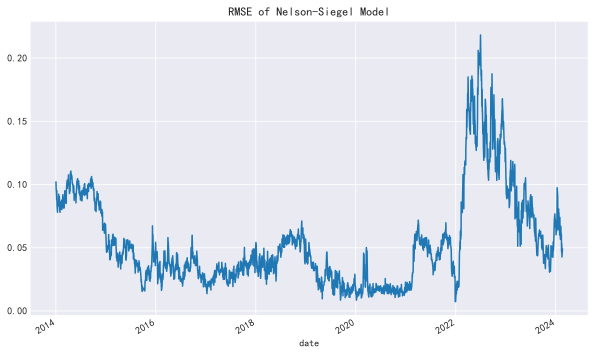

In [11]:
param_df['rmse'].plot(figsize=(10, 6), title='RMSE of Nelson-Siegel Model')

The overall error is much smaller. We now take a grid of $\lambda$ and find the optimal $\lambda$ that minimizes the cross-validation error.

In [21]:
%%time
from sklearn.metrics import mean_squared_error

def Nelson_Siegel(T, beta_0, beta_1, beta_2, lambda_):
    term1 = (1 - np.exp(-lambda_ * T)) / (lambda_ * T)
    term2 = term1 - np.exp(-lambda_ * T)
    Y = beta_0 + (beta_1 * term1) + (beta_2 * term2)
    return Y

# Define the calibration function
def calibrate_NS(T, Y_observed, lambda_):
    # Initial guesses for the parameters
    initial_guess = [0.05, -0.04, -0.05]

    # Use curve_fit to calibrate the parameters (nonlinear least squares)
    params, covariance = curve_fit(lambda T, beta_0, beta_1, beta_2: Nelson_Siegel(T, beta_0, beta_1, beta_2, lambda_), T, Y_observed, p0=initial_guess, maxfev=5000)

    # Calculate the fitted yield values
    Y_fit = Nelson_Siegel(T, *params, lambda_)

    # Calculate the RMSE
    rmse = np.sqrt(mean_squared_error(Y_observed, Y_fit))

    return params, rmse

T_values = np.array([0.25, 0.5, 1, 2, 3, 5, 7, 10])  # Maturity values

lambda_values = np.linspace(0.2, 1, 50)  # Grid of lambda values around 1/3.33

result_df = pd.DataFrame(index=lambda_values, columns=['total_rmse'], dtype=float)

# Grid search for the best lambda value
for lambda_ in lambda_values:
    total_rmse = 0
    for idx, row in df.iterrows():
        Y_observed = row.values
        params, rmse = calibrate_NS(T_values, Y_observed, lambda_)
        total_rmse += rmse
    result_df.loc[lambda_, 'total_rmse'] = total_rmse
    
result_df.index.name = 'lambda'        
result_df

Wall time: 59.8 s


,total_rmse
lambda,
0.200000,148.514579
0.216327,146.383475
0.232653,144.249056
0.248980,142.118342
0.265306,139.999097
0.281633,137.899358
0.297959,135.826932
0.314286,133.788957
0.330612,131.791639


<AxesSubplot:title={'center':'Total RMSE of NS Model for Different Lambda'}, xlabel='lambda'>

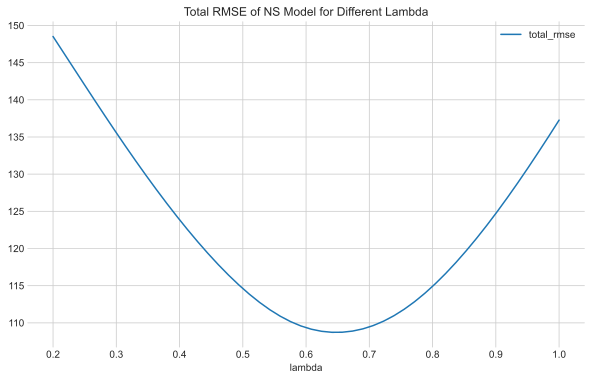

In [22]:
result_df.plot(figsize=(10, 6), title='Total RMSE of NS Model for Different Lambda')

In [23]:
print("Best Lambda: ", result_df['total_rmse'].idxmin())
print("Best total RMSE: ", result_df['total_rmse'].min())

Best Lambda:  0.6408163265306124
Best total RMSE:  108.72742324799074


We see from the error plot a clear decreasing and then increasing pattern in the total RMSE as $\lambda$ increases. The optimal $\lambda$ is around $0.64$, we will use this $\lambda$ to calibrate the model again.

<AxesSubplot:title={'center':'RMSE of Nelson-Siegel Model'}, xlabel='date'>

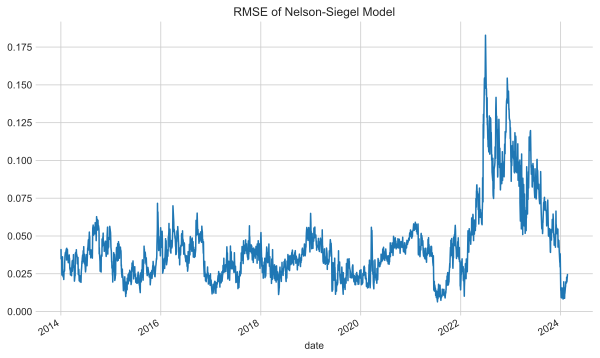

In [24]:
from sklearn.metrics import mean_squared_error

best_lambda = result_df['total_rmse'].idxmin()

def Nelson_Siegel(T, beta_0, beta_1, beta_2):
    lambda_ = best_lambda
    term1 = (1 - np.exp(-lambda_ * T)) / (lambda_ * T)
    term2 = term1 - np.exp(-lambda_ * T)
    Y = beta_0 + (beta_1 * term1) + (beta_2 * term2)
    return Y

from scipy.optimize import curve_fit

# Define the calibration function
def calibrate_NS(T, Y_observed):
    # Initial guesses for the parameters
    initial_guess = [0.05, -0.04, -0.05]

    # Use curve_fit to calibrate the parameters (nonlinear least squares)
    params, covariance = curve_fit(Nelson_Siegel, T, Y_observed, p0=initial_guess, maxfev=5000)

    # Calculate the fitted yield values
    Y_fit = Nelson_Siegel(T, *params)

    # Calculate the RMSE
    rmse = np.sqrt(mean_squared_error(Y_observed, Y_fit))

    return params, rmse

T_values = np.array([0.25, 0.5, 1, 2, 3, 5, 7, 10])  # Maturity values
fitted_df = pd.DataFrame(index=df.index, columns=df.columns, dtype=float)

param_df = pd.DataFrame(index=df.index, columns=['beta_0', 'beta_1', 'beta_2', 'rmse'], dtype=float)

for idx, row in df.iterrows():
    Y_observed = row.values
    params, rmse = calibrate_NS(T_values, Y_observed)
    param_df.loc[idx, ['beta_0', 'beta_1', 'beta_2']] = params
    param_df.loc[idx, 'rmse'] = rmse

    Y_fit = Nelson_Siegel(T_values, *params)
    fitted_df.loc[idx] = Y_fit

param_df['rmse'].plot(figsize=(10, 6), title='RMSE of Nelson-Siegel Model')

**Stability of the level, shape, and curvature parameter**
- The level parameter $\beta_0$ is the long-term interest rate level, and is relatively stable over time around 4%
- The slope parameter $\beta_1$ is the long-to-short-term spread. It varies between -4% to 0 and goes up and down but is relatively stable
- The curvature parameter $\beta_2$ is the most volatile and varies between -6% and 6%

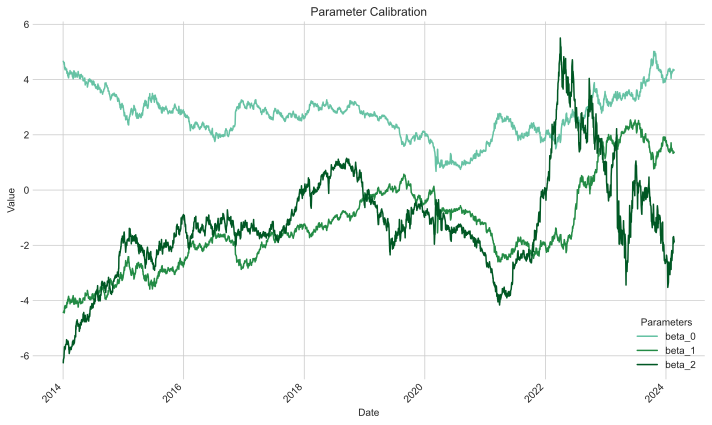

In [25]:
from matplotlib.colors import LinearSegmentedColormap
colors = ["#66c2a4", "#238b45", "#005824"]
teal_cmap = LinearSegmentedColormap.from_list("TealCmap", colors)

param_df[['beta_0', 'beta_1', 'beta_2']].plot(figsize=(10, 6), colormap=teal_cmap) 
plt.title('Parameter Calibration')
plt.xlabel('Date')
plt.ylabel('Value')
plt.xticks(rotation=45)
plt.legend(title='Parameters')
plt.tight_layout()
plt.show()

### **Trading Strategies**

In [26]:
param_df.drop(columns='rmse', inplace=True)
param_df.head()

,beta_0,beta_1,beta_2
date,,,
2014-01-02,4.661074,-4.425732,-6.252194
2014-01-03,4.650499,-4.425174,-6.139644
2014-01-06,4.595576,-4.391762,-6.066153
2014-01-07,4.547807,-4.359044,-5.927395
2014-01-08,4.613185,-4.444668,-5.836797


By analyzing the statistical properties, we find the three parameters have extremely high auto-correlation.

In [27]:
# statistical properties of the parameters
from scipy.stats import kurtosis, skew
param_stat = param_df.describe().T
param_stat['skew'] = param_df.apply(skew)
param_stat['kurtosis'] = param_df.apply(kurtosis)

# calculate lag autocorrelation
for col in param_df.columns:
    for lag in range(1, 4):
        param_stat[f'autocorr_{lag}'] = param_df[col].autocorr(lag=lag)
param_stat.T


,beta_0,beta_1,beta_2
count,2522.000000,2522.000000,2522.000000
mean,2.704715,-1.291979,-1.150757
std,0.830711,1.609220,1.868274
min,0.677535,-4.444668,-6.252194
25%,2.174968,-2.402360,-2.058211
50%,2.745124,-1.573666,-1.360368
75%,3.171902,-0.262454,-0.232142
max,5.018714,2.539865,5.505167
skew,-0.050263,0.457667,0.449439
kurtosis,-0.048262,-0.345875,1.093661


The parameter values are non-stationary

In [28]:
from statsmodels.tsa.stattools import adfuller

def adf_test(timeseries):
    # Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print (dfoutput)
    if dftest[1] <= 0.05:
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
        
    else:
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")
        
    return

for col in param_df.columns:
    print(col)
    adf_test(param_df[col])
    print('\n')
    
    

beta_0
Results of Dickey-Fuller Test:
Test Statistic                   -2.082560
p-value                           0.251585
#Lags Used                        1.000000
Number of Observations Used    2520.000000
Critical Value (1%)              -3.432948
Critical Value (5%)              -2.862688
Critical Value (10%)             -2.567381
dtype: float64
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


beta_1
Results of Dickey-Fuller Test:
Test Statistic                   -1.320919
p-value                           0.619549
#Lags Used                        0.000000
Number of Observations Used    2521.000000
Critical Value (1%)              -3.432947
Critical Value (5%)              -2.862687
Critical Value (10%)             -2.567381
dtype: float64
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


beta_2
Results of Dickey-Fuller Test:
Test Statistic                   -2.784872
p-value                           0.060467
#Lags Us

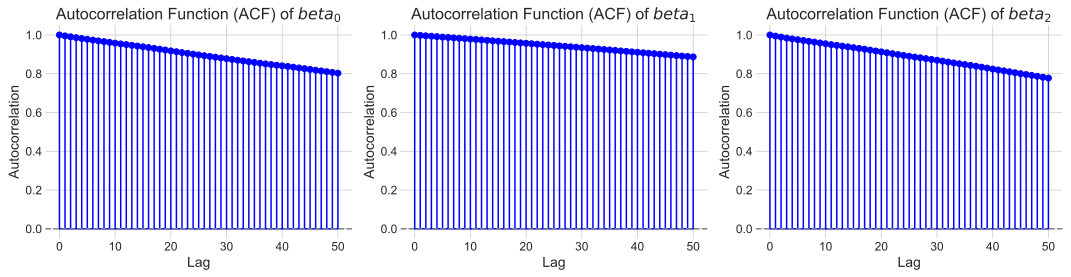

In [29]:
from statsmodels.tsa.stattools import acf
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

fig, axs = plt.subplots(1, 3, figsize=(15, 4))  # Create a figure and a 1x3 grid of subplots

for i, beta in enumerate(['beta_0', 'beta_1', 'beta_2']):
    acf_result = acf(param_df[beta], nlags=50, fft=False)
    axs[i].stem(range(len(acf_result)), acf_result, basefmt="b-", linefmt="b-", markerfmt='bo')
    axs[i].set_title(r'Autocorrelation Function (ACF) of ${}$'.format(beta), fontsize=16)
    axs[i].set_xlabel('Lag', fontsize=14)
    axs[i].set_ylabel('Autocorrelation', fontsize=14)
    axs[i].axhline(y=0, linestyle='--', color='gray') 
    axs[i].tick_params(labelsize=12)

plt.tight_layout()  
plt.show()